$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\R}{\mathbb{R}}$
$\renewcommand{\N}{\mathbb{N}}$
$\newcommand{\C}{\mathbb{C}}$
$\newcommand{\cH}{\mathcal{H}}$
$\newcommand{\T}{\mathsf{T}}$
$\newcommand{\lift}{g}$
$\newcommand{\embed}{f}$
$\newcommand{\featuremap}{h}$
$\newcommand{\kronfeaturemap}{h_{\mathrm{quad}}}$
$\newcommand{\liftlin}{g_\mathrm{lin}}$
$\newcommand{\embedlin}{f_\mathrm{lin}}$
$\newcommand{\liftnonlin}{g}$
$\newcommand{\embednonlin}{f_\mathrm{mod}}$
$\newcommand{\nfull}{{n}}$
$\newcommand{\nsnapshots}{k}$
$\newcommand{\nred}{r}$
$\newcommand{\nredmod}{{p}}$
$\newcommand{\vbarconsider}{q}$
$\newcommand{\nconsider}{m}$
$\newcommand{\ntheta}{n_\theta}$
$\newcommand{\iterationCounter}{i}$
$\newcommand{\fullstate}{\mathbf{s}}$
$\newcommand{\fullstatei}[1]{\mathbf{s}^{(#1)}}$
$\newcommand{\refstate}{\mathbf{s}_{\mathrm{ref}}}$
$\newcommand{\redstate}{\mathbf{s}_r}$
$\newcommand{\redstatesub}[1]{\mathbf{s}_{r, #1}}$
$\newcommand{\redstatei}[1]{\mathbf{s}^{(#1)}_r}$
$\newcommand{\recoveredstate}{\hat \fullstate}$
$\newcommand{\recstatei}[1]{\mathbf{\hat s}^{(#1)}}$
$\newcommand{\snapshots}{\mathbf{S}}$
$\newcommand{\podbasis}{\mathbf{V}}$
$\newcommand{\quadmap}{\mathbf{\bar V}_r}$
$\newcommand{\USVD}{\mathbf{\Phi}}$
$\newcommand{\SigmaSVD}{\mathbf{\Sigma}}$
$\newcommand{\VSVD}{\mathbf{\Psi}}$
$\newcommand{\USVDi}[1]{\mathbf{\phi}^{(#1)}}$
$\newcommand{\SigmaSVDi}[1]{\mathbf{\sigma}_{#1}}$
$\newcommand{\VSVDi}[1]{\mathbf{\psi}^{(#1)}}$
$\newcommand{\testbasis}{\Theta}$
$\newcommand{\testbasisComplement}{\bar \Theta}$
$\newcommand{\reconstructionError}{\mathbf{E}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\maniXi}{\mathbf{\Xi}}$
$\newcommand{\manifold}{\mathcal{M}}$
$\newcommand{\WUSVD}{\mathbf{\Phi}_{\featureMatrix_j}}$
$\newcommand{\WSigmaSVD}{\mathbf{\Sigma}_{\featureMatrix_j}}$
$\newcommand{\WVSVD}{\mathbf{\Psi}_{\featureMatrix_j}}$
$\newcommand{\Vlin}{\mathbf{V}}$
$\newcommand{\Vnonlin}{\mathbf{W}}$
$\newcommand{\Vnonlinhat}{\mathbf{\hat W}}$
$\newcommand{\featureMatrix}{\mathbf{H}}$
$\newcommand{\procrustesSol}{\mathbf{P}}$

# A greedy construction of quadratic manifolds: Overview and Quick Example

In this notebook, we use quadratic manifolds to determine a reduced representation for a given set of high dimensional data points. We first show that quadratic manifolds as introduced in [<span style="color:green">1</span>] can achieve a smaller reconstruction error than a linear reconstruction by principal component analysis. After that, we show how our new greedy construction method for quadratic manifolds [<span style="color:green">2</span>] can further reduce the reconstruction error by several orders of magnitude.

For our demonstration, we consider data points that describe an advecting Gaussian pulse in the 1-dimensional spatial domain $[0, 1]$.
These data points are high dimensional because the advecting Gaussian pulse is discretized in a fine grid with $2^{12}$ grid points.
The data is defined and visualized as follows.

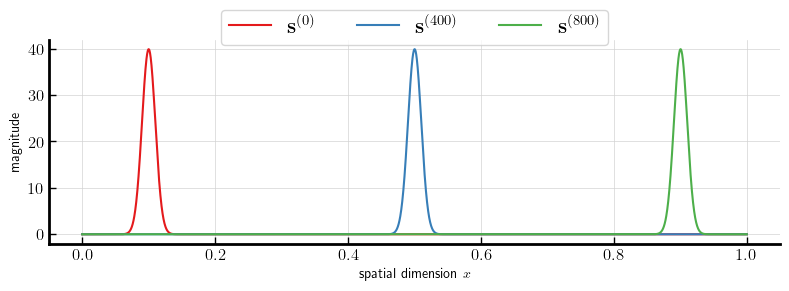

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

jax.config.update('jax_enable_x64', True)

PULSE_WIDTH = 2.0e-4
PULSE_SHIFT = 1.0e-1
SPEED = 10.0
FINAL_TIME = 0.1
N_TIME_SAMPLES = 2000
N_SPACE_SAMPLES = 2**12

def gaussian_pulse(x):
  return 1 / jnp.sqrt(PULSE_WIDTH*jnp.pi) * jnp.exp(-((x-PULSE_SHIFT))**2 / PULSE_WIDTH)

def generate_data():
  t = jnp.linspace(0, FINAL_TIME, N_TIME_SAMPLES)

  def f(x, ti):
    u = gaussian_pulse(x-SPEED * ti)
    return x, u
  
  _, data_points = jax.lax.scan(f, x, t)
  return data_points.T

x = jnp.linspace(0, 1, N_SPACE_SAMPLES)
data = generate_data()
train_data = data[:, ::2]
test_data = data[:, 1::2]


fig = plt.figure(figsize=(8, 3))
for i in [0, 400, 800]:
  plt.plot(x, train_data[:, i], label=r'$\mathbf{s}^{('+f'{i}'+r')}$')
plt.xlabel("spatial dimension $x$")
plt.ylabel("magnitude")
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2), fontsize=15.0)


We divide the data points into `train_data` and `test_data`.

## Linear dimensionality reduction

A widely used dimensionality reduction method is principal component analysis (PCA).
We derive the principal components by computing a singular value decomposition (SVD) of the data matrix $\snapshots =[\fullstatei{1}, \dots, \fullstatei{k}] \in \R^{\nfull \times \nsnapshots}$, which consists of the $\nsnapshots$ given training data points.
The SVD of the data matrix is computed as $\USVD \SigmaSVD \VSVD^\top = \snapshots$.
Now, we define a *reduction map* $\embedlin: \R^{\nfull} \to \R^{\nred}$ that computes reduced coordinates for a given data point via $\embedlin(\fullstate) = \Vlin^\top \fullstate$ and a *lifting map* $\liftlin: \R^{\nred} \to \R^{\nfull}$ that reconstructs data points from reduced coordinates via $\liftlin(\redstate) = \Vlin \redstate$
In the following cells, we investigate the reconstruction accuracy, that can be achieved, when using this linear approach for dimensionality reduction.
As a preprocessing step, we shift the data matrix $\snapshots$ by its column-wise mean value before computing the SVD.

In [2]:
from jax.numpy.linalg import svd, norm

def shift_data(data_points, shift):
  return (data_points.T-shift.T).T

data_shift = jnp.mean(train_data, axis=1)
Phi, Sigma, PsiT = svd(shift_data(train_data, data_shift))

Text(0, 0.5, 'relative error')

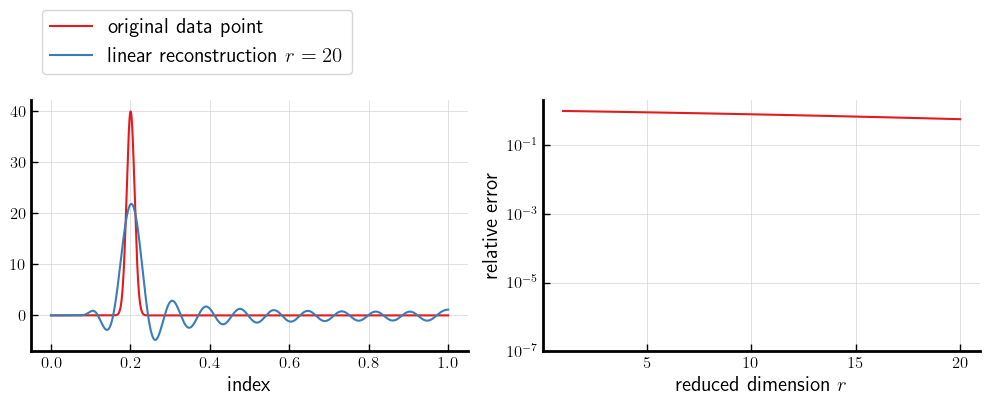

In [3]:
def linear_reduce(V, data_points):
  return V.T @ shift_data(data_points, data_shift)


def linear_lift(V, reduced_data_points):
  return shift_data(V @ reduced_data_points, -data_shift)


def linear_reconstruction_error(V, data_points):
  reduced_data_points = linear_reduce(V, data_points)
  return norm(data_points - linear_lift(V, reduced_data_points)) / norm(data_points)


linear_reconstruction_errors = [linear_reconstruction_error(
  Phi[:, :r], test_data) for r in range(1, 21)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

V_lin_20 = Phi[:, :20]
axs[0].plot(x, test_data[:, 100], label='original data point')
axs[0].plot(x, linear_lift(V_lin_20, linear_reduce(V_lin_20, jnp.expand_dims(
  test_data[:, 100], 1))), label='linear reconstruction $r=20$')
axs[0].legend(ncol=1, loc='upper left', bbox_to_anchor=(0.0, 1.4), fontsize=15)
axs[0].set_xlabel('index', fontsize=15)

axs[1].semilogy(range(1, 21), linear_reconstruction_errors)
axs[1].set_ylim(1e-7, 2)
axs[1].set_xlabel('reduced dimension $r$', fontsize=15)
axs[1].set_ylabel('relative error', fontsize=15)

This test demonstrates that using linear dimensionality reduction, we cannot accurately reconstruct data points from the linear transport data set even when using moderately a high reduced dimension of $\nred=20$. Moreover, as we increase the reduced dimension $\nred$, the relative error only decays slowly. In [<span style="color:green">2</span>] it is demonstrated that for an efficient reduction of data that includes advection, nonlinear reduction techniques are better suited.

## Dimensionality reduction using quadratic manifolds

The main idea in [<span style="color:green;">1</span>] is to decrease the approximation error of the linear reconstruction by using a nonlinear lifting map.
For this, a nonlinear feature map $\featuremap: \R^{\nred} \to \R^{\nredmod}$ is applied to the reduced data points before computing an extended lifting map
\begin{align}
\lift_{\text{ext}}(\redstate) = \Vlin \redstate + \Vnonlin h(\redstate),
\end{align}
which contains an additional nonlinear part $\Vnonlin h(\redstate)$.
For computing the reduced coordinates, the linear map from before is used, i.e. $\embedlin(\fullstate) = \Vlin^\top \fullstate$.

In [<span style="color:green;">1</span>], $\Vlin$ consists of the first $\nred$ singular vectors (as in the SVD-based linear reconstruction), the feature map $\featuremap$ is a fixed quadratic function, defined as the funciton `feature_map` in the following cell, and $\Vnonlin$ is determined as a corrector to the residual of the linear reconstruction by solving a linear least squares problem. In this way, only one extra step is added.

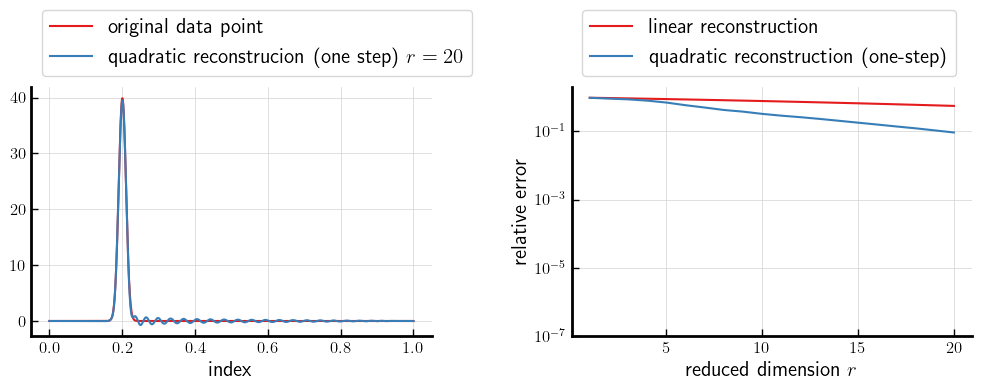

In [4]:
def lstsq_l2(A, B, reg_magnitude=1e-6):
  PHI, SIGMA, PSI_T = svd(A, full_matrices=False)
  sinv = SIGMA / (SIGMA**2 + reg_magnitude**2)
  x = PSI_T.T * sinv @ (PHI.T @ B)
  B_estimate = A @ x
  resid = norm(B - B_estimate)
  return x, resid


def default_feature_map(reduced_data_points):
  r = reduced_data_points.shape[0]
  return jnp.concatenate(
    [reduced_data_points[i] * reduced_data_points[:i + 1] for i in range(r)],
    axis=0
  )


def compute_W(V, feature_map, data_points):
  linear_residual = data_points - linear_lift(V, linear_reduce(V, data_points))
  reduced_data_points = linear_reduce(V, data_points)
  A = feature_map(reduced_data_points).T
  W, _ = lstsq_l2(A, linear_residual.T)
  return W.T


def lift_quadratic(V, W, feature_map, reduced_data_points):
  linear_part = V @ reduced_data_points
  quadratic_part = W @ feature_map(reduced_data_points)
  return shift_data(linear_part + quadratic_part, -data_shift)


def quadratic_reconstruction_error(V, W, feature_map, data_points):
  reduced_data_points = linear_reduce(V, data_points)
  abs_err = norm(data_points - lift_quadratic(V, W, feature_map, reduced_data_points))
  return abs_err / norm(data_points)


def compute_quadratic_errors(r):
  V = Phi[:, :r]
  W = compute_W(V, default_feature_map, train_data)
  return quadratic_reconstruction_error(V, W, default_feature_map, test_data)


quadratic_reconstruction_errors = [compute_quadratic_errors(r) for r in range(1, 21)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

V_20 = Phi[:, :20]
W_20 = compute_W(V_20, default_feature_map, train_data)
quad_reconsruction_20 = lift_quadratic(V_20, W_20, default_feature_map, linear_reduce(
  V_20, jnp.expand_dims(test_data[:, 100], 1)))[:, 0]

axs[0].plot(x, test_data[:, 100], label='original data point')
axs[0].plot(x, quad_reconsruction_20, label='quadratic reconstrucion (one step) $r=20$')
axs[0].legend(ncol=1, loc='lower left', bbox_to_anchor=(0.0, 1.0), fontsize=15)
axs[0].set_xlabel('index', fontsize=15)

axs[1].semilogy(range(1, 21), linear_reconstruction_errors, label='linear reconstruction')
axs[1].semilogy(range(1, 21), quadratic_reconstruction_errors, label='quadratic reconstruction (one-step)')
axs[1].set_ylim(1e-7, 2)
axs[1].set_xlabel('reduced dimension $r$', fontsize=15)
axs[1].set_ylabel('relative error', fontsize=15)
axs[1].legend(ncol=1, loc='lower left', bbox_to_anchor=(0.0, 1.0), fontsize=15)

The quadratic reconstruction leads to a notable improvement but there are still visible artificial oscillations in the reconstructed data point.

## Our modification: Greedy column selection

In our preprint [<span style="color:green">3</span>], we argue that while the first $\nred$ columns of $\USVD$ are the best choice, when computing a linear reconstruction, this is not always true, when the extended lifting map as defined in $(1)$ is used for data reconstruction. Therefore, we construct $\Vlin$ iteratively (column-by-column).

In each iteration, we add a new column to $\Vlin$ and always choose a singular vector, that minimizes the reconstruction error of the resulting quadratic manifold. This can be implemented as follows.

In [5]:
from jax.numpy import hstack, expand_dims, inf

def compute_manifold_greedy_slow(Phi, data_points, r, n_vectors_to_check=None):
  if n_vectors_to_check == None:
    n_vectors_to_check = data_points.shape[1]
  V = jnp.zeros((data_points.shape[0], 0))
  for _ in range(r):
    lowest_error_idx = -1
    lowest_error_value = inf
    for j in range(n_vectors_to_check):
      V_test = hstack((V, expand_dims(Phi[:, j], 1)))
      W_test = compute_W(V_test, default_feature_map, data_points)
      reduced_data_points = linear_reduce(V_test, data_points)
      abs_reconstruction_err = norm(data_points - lift_quadratic(V_test, W_test, default_feature_map, reduced_data_points))
      if abs_reconstruction_err < lowest_error_value:
        lowest_error_idx = j
        lowest_error_value = abs_reconstruction_err
    V = hstack((V, expand_dims(Phi[:, lowest_error_idx], 1)))
  W = compute_W(V, default_feature_map, data_points)
  return V, W

In [6]:
%timeit compute_manifold_greedy_slow(Phi, train_data, 5, 50)

28.2 s ± 676 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using this implementation, the runtime is excessive. This is because we solve $\nconsider=$`n_vectors_to_check` linear least-squares problems in each of the $\nred$ iterations and reassemble the components of the least-squares problem.

Therefore, in Section 3.3 of our preprint [<span style="color:green">3</span>], we develop strategies that allow us to reuse several computations and reduce the overall dimension of the problem.

In [7]:
from jax.lax import fori_loop


def quadmani_greedy(Phi, Sigma, PsiT, r, n_vectors_to_check, feature_map=default_feature_map):
  idx_in = jnp.arange(0, 0, 1)
  idx_out = jnp.arange(0, len(Sigma), 1)
  idx_in, idx_out = greedy_step_fast(
      idx_in,
      idx_out,
      Sigma,
      PsiT,
      imax=n_vectors_to_check,
      nonlinear_map=feature_map,
  )
  for _ in range(r - 1):
    idx_in, idx_out = greedy_step_fast(
        idx_in,
        idx_out,
        Sigma,
        PsiT,
        imax=n_vectors_to_check,
        nonlinear_map=feature_map,
    )
  V = Phi[:, idx_in]
  SIGMA1, SIGMA2 = Sigma[idx_in], Sigma[idx_out]
  V1T, V2T = PsiT[idx_in, :], PsiT[idx_out, :]
  embedded_snapshots = jnp.diag(SIGMA1) @ V1T
  V2S2 = V2T.T * SIGMA2
  H = feature_map(embedded_snapshots)
  W, _ = lstsq_l2(H.T, V2S2)
  return V, Phi[:, idx_out] @ W.T


def greedy_step_fast(
    idx_in_pre, idx_out_pre, SIGMA, VT, imax, nonlinear_map
):
  def body_fun(i, errors):
    idx_in = jnp.hstack((idx_in_pre, idx_out_pre[i]))
    idx_out = jnp.delete(idx_consider, i, assume_unique_indices=True)
    errors = errors.at[i].set(
        compute_error_fast(idx_in, idx_out, SIGMA, VT, nonlinear_map)
    )
    return errors

  n_consider = jnp.minimum(imax, len(idx_out_pre))
  errors = jnp.zeros(shape=(n_consider,))
  idx_consider = idx_out_pre[:n_consider]
  errors = fori_loop(0, len(errors), body_fun, errors)
  idx = jnp.argmin(errors)
  idx_in_next = jnp.hstack((idx_in_pre, idx_out_pre[idx]))
  idx_out_next = jnp.delete(idx_out_pre, idx)
  return idx_in_next, idx_out_next


def compute_error_fast(idx_in, idx_out, SIGMA, VT, feature_map):
  SIGMA1, SIGMA2 = SIGMA[idx_in], SIGMA[idx_out]
  V1T, V2T = VT[idx_in, :], VT[idx_out, :]
  embedded_snapshots = jnp.diag(SIGMA1) @ V1T
  V2S2 = V2T.T * SIGMA2
  W = feature_map(embedded_snapshots)
  _, residuals = lstsq_l2(W.T, V2S2)
  return residuals

In [8]:
%timeit quadmani_greedy(Phi, Sigma, PsiT, 5, 50)

562 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Our modified implementation only uses around 2% of the original runtime in this example but yields the same result for $\Vlin$ and $\Vnonlin$. In the following, we show the accuracy improvement that can be achieved when using our greedy column selection strategy.

In [9]:
def compute_greedy_quadratic_errors(r):
  errs=[]
  idx_in = jnp.arange(0, 0, 1)
  idx_out = jnp.arange(0, len(Sigma), 1)
  idx_in, idx_out = greedy_step_fast(
      idx_in,
      idx_out,
      Sigma,
      PsiT,
      imax=200,
      nonlinear_map=default_feature_map,
  )
  V = Phi[:, idx_in]
  SIGMA1, SIGMA2 = Sigma[idx_in], Sigma[idx_out]
  V1T, V2T = PsiT[idx_in, :], PsiT[idx_out, :]
  embedded_snapshots = jnp.diag(SIGMA1) @ V1T
  V2S2 = V2T.T * SIGMA2
  H = default_feature_map(embedded_snapshots)
  W, _ = lstsq_l2(H.T, V2S2)
  errs.append(quadratic_reconstruction_error(V, Phi[:, idx_out] @ W.T, default_feature_map, test_data))
  for _ in range(r - 1):
    idx_in, idx_out = greedy_step_fast(
        idx_in,
        idx_out,
        Sigma,
        PsiT,
        imax=200,
        nonlinear_map=default_feature_map,
    )
    V = Phi[:, idx_in]
    SIGMA1, SIGMA2 = Sigma[idx_in], Sigma[idx_out]
    V1T, V2T = PsiT[idx_in, :], PsiT[idx_out, :]
    embedded_snapshots = jnp.diag(SIGMA1) @ V1T
    V2S2 = V2T.T * SIGMA2
    H = default_feature_map(embedded_snapshots)
    W, _ = lstsq_l2(H.T, V2S2 @ Phi[:, idx_out].T)
    errs.append(quadratic_reconstruction_error(V, W.T, default_feature_map, test_data))
  return errs


greedy_quadratic_reconstruction_errors = jnp.stack(compute_greedy_quadratic_errors(20))
V_20, W_20 = quadmani_greedy(Phi, Sigma, PsiT, 20, 200, default_feature_map)
greedy_quad_reconsruction_20 = lift_quadratic(V_20, W_20, default_feature_map, linear_reduce(
    V_20, jnp.expand_dims(test_data[:, 100], 1)))[:, 0]


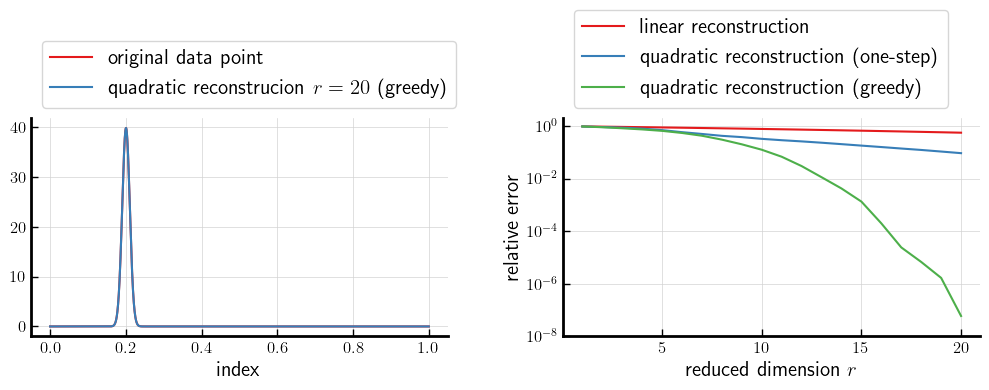

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(x, test_data[:, 100], label='original data point')
axs[0].plot(x, greedy_quad_reconsruction_20,
            label='quadratic reconstrucion $r=20$ (greedy)')
axs[0].legend(ncol=1, loc='lower left', bbox_to_anchor=(0.0, 1.0), fontsize=15)
axs[0].set_xlabel('index', fontsize=15)

axs[1].semilogy(range(1, 21), linear_reconstruction_errors, label='linear reconstruction')
axs[1].semilogy(range(1, 21), quadratic_reconstruction_errors, label='quadratic reconstruction (one-step)')
axs[1].semilogy(range(1, 21), greedy_quadratic_reconstruction_errors, label='quadratic reconstruction (greedy)')
axs[1].set_ylim(1e-8, 2)
axs[1].set_xlabel('reduced dimension $r$', fontsize=15)
axs[1].set_ylabel('relative error', fontsize=15)
axs[1].legend(ncol=1, loc='lower left', bbox_to_anchor=(0.0, 1.0), fontsize=15)

Using the greedy construction of $\Vlin$, no artificial oscillations are visible in the data point reconstruction and the reconstruction error is lower by several orders of magnitude.

### Further remarks

- In [<span style="color:green">4</span>], an alternating minimization strategy is introduced that computes $\Vlin$ and $\Vnonlin$ simultaneously. In our preprint we show that this leads to a similar reconstruction error as the greedy column selection but comes at a much higher computational cost due to the sublinear convergence of the alternating minimization scheme.
- The greedy column selection also leads to a higher robustness of the quadratic manifold construction, i.e. it is less dependent on the regularization magnitude.
- The method can be generalized to other nonlinear feature maps. In the provided implementation `quadmani_greedy`, the function `featuremap` is in fact passed as a parameter.

### References
[<span style="color:green">1</span>] R. Geelen, S. Wright, and K. Willcox, Operator inference for non-intrusive model reduction with quadratic manifolds, Comput. Methods Appl. Mech. Engrg., 403 (2023), p. 115717 <BR>
[<span style="color:green">2</span>] B. Peherstorfer. Breaking the Kolmogorov barrier with nonlinear model reduction. Notices Amer. Math. Soc., 69:725–733, 2022. <BR>
[<span style="color:green">3</span>] P. Schwerdtner and B. Peherstorfer, A greedy construction of quadratic manifolds for nonlinear dimensionality
reduction, 2024 (to appear) <BR>
[<span style="color:green">4</span>] R. Geelen, L. Balzano, and K. Willcox, Learning latent representations in high-dimensional state
spaces using polynomial manifold constructions, 2023

### Code to copy

If you want to test our greedy manifold construction, you can copy the code-cell below or include the file `quadmani.py`, which is also contained in this repository.
1. Call `quadmani_greedy` to compute $\Vlin$, $\Vnonlin$, and a shift value that centers the data.
2. To reduce new data points, call `linear_reduce`.
3. To reconstruct reduced data points, call `lift_quadratic`.

Feel free to modify the shift computation, regularization magnitude or define your own feature map.

In [11]:
import jax
import jax.numpy as jnp
from jax.lax import fori_loop

jax.config.update('jax_enable_x64', True)

def default_feature_map(reduced_data_points):
  r = reduced_data_points.shape[0]
  return jnp.concatenate(
    [reduced_data_points[i] * reduced_data_points[:i + 1] for i in range(r)],
    axis=0
  )


def quadmani_greedy(data_points, r=20, n_vectors_to_check=200, feature_map=default_feature_map):
  shift_value = jnp.mean(data_points, axis=1)
  Phi, Sigma, PsiT = jnp.linalg.svd(shift_data(data_points, shift_value))
  idx_in = jnp.arange(0, 0, 1)
  idx_out = jnp.arange(0, len(Sigma), 1)
  idx_in, idx_out = greedy_step_fast(
      idx_in,
      idx_out,
      Sigma,
      PsiT,
      imax=n_vectors_to_check,
      nonlinear_map=feature_map,
  )
  for _ in range(r - 1):
    idx_in, idx_out = greedy_step_fast(
        idx_in,
        idx_out,
        Sigma,
        PsiT,
        imax=n_vectors_to_check,
        nonlinear_map=feature_map,
    )
  V = Phi[:, idx_in]
  SIGMA1, SIGMA2 = Sigma[idx_in], Sigma[idx_out]
  V1T, V2T = PsiT[idx_in, :], PsiT[idx_out, :]
  embedded_snapshots = jnp.diag(SIGMA1) @ V1T
  V2S2 = V2T.T * SIGMA2
  H = feature_map(embedded_snapshots)
  W, _ = lstsq_l2(H.T, V2S2)
  return V, Phi[:, idx_out] @ W.T, shift_value


def lstsq_l2(A, B, reg_magnitude=1e-6):
  PHI, SIGMA, PSI_T = jnp.linalg.svd(A, full_matrices=False)
  sinv = SIGMA / (SIGMA**2 + reg_magnitude**2)
  x = PSI_T.T * sinv @ (PHI.T @ B)
  B_estimate = A @ x
  resid = jnp.linalg.norm(B - B_estimate)
  return x, resid


def greedy_step_fast(
    idx_in_pre, idx_out_pre, SIGMA, VT, imax, nonlinear_map
):
  def body_fun(i, errors):
    idx_in = jnp.hstack((idx_in_pre, idx_out_pre[i]))
    idx_out = jnp.delete(idx_consider, i, assume_unique_indices=True)
    errors = errors.at[i].set(
        compute_error_fast(idx_in, idx_out, SIGMA, VT, nonlinear_map)
    )
    return errors

  n_consider = jnp.minimum(imax, len(idx_out_pre))
  errors = jnp.zeros(shape=(n_consider,))
  idx_consider = idx_out_pre[:n_consider]
  errors = fori_loop(0, len(errors), body_fun, errors)
  idx = jnp.argmin(errors)
  idx_in_next = jnp.hstack((idx_in_pre, idx_out_pre[idx]))
  idx_out_next = jnp.delete(idx_out_pre, idx)
  return idx_in_next, idx_out_next


def compute_error_fast(idx_in, idx_out, SIGMA, VT, feature_map):
  SIGMA1, SIGMA2 = SIGMA[idx_in], SIGMA[idx_out]
  V1T, V2T = VT[idx_in, :], VT[idx_out, :]
  embedded_snapshots = jnp.diag(SIGMA1) @ V1T
  V2S2 = V2T.T * SIGMA2
  W = feature_map(embedded_snapshots)
  _, residuals = lstsq_l2(W.T, V2S2)
  return residuals


def shift_data(data_points, shift):
  return (data_points.T - shift.T).T


def linear_reduce(V, data_points, shift_value):
  return V.T @ shift_data(data_points, -shift_value)


def lift_quadratic(V, W, shift_value, reduced_data_points, feature_map=default_feature_map):
  linear_part = V @ reduced_data_points
  quadratic_part = W @ feature_map(reduced_data_points)
  return shift_data(linear_part + quadratic_part, shift_value)